In [ ]:
import numpy as np
import matplotlib.pyplot as plt
mpy = np.random.random((9,16,16,2))-0.5
m = np.squeeze(mpy[:,:,:,0])
print(m.shape)

In [ ]:
figure = plt.figure(figsize=(10,10))
if len(m.shape)==3:
    for i in range(min(9, m.shape[0])):
        ax = figure.add_subplot(3,3,i+1)
        im = ax.matshow(np.squeeze(m[i,:,:]), cmap='RdBu_r')
        im.set_clim(0.001, 1.001)
    plt.tight_layout()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

data = np.arange(25).reshape(5,5)/4.0
figure = plt.figure(figsize=(10,10))
ax = figure.subplots()
im = ax.matshow(data, cmap='RdBu_r', clim=[0.0, 1.0])
norm = mpl.colors.Normalize(vmin=0.0, vmax=1.0)
figure.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap='RdBu_r'))
for (i, j), z in np.ndenumerate(data):
    ax.text(j, i, '{:2.2f}'.format(z), ha='center', va='center',
    bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
plt.show()

In [6]:
import model
import glob
import imageio
import time
import datetime
from IPython import display
import matplotlib.pyplot as plt
from iced import normalization
import cooler
import numpy as np
import copy

import tensorflow as tf
tf.keras.backend.set_floatx('float32')


# data from ftp://cooler.csail.mit.edu/coolers/hg19/
name = 'Dixon2012-H1hESC-HindIII-allreps-filtered.10kb.cool'
#name = 'Rao2014-K562-MboI-allreps-filtered.500kb.cool'
c = cooler.Cooler(name)
resolution = c.binsize
mat = c.matrix(balance=True).fetch('chr2')
idxy = ~np.all(np.isnan(mat), axis=0)
M = mat[idxy, :]
Mh = M[:, idxy]
print('MH: ', Mh.shape)
Mh = Mh[0:1024, 0:1024]
print('MH: ', Mh.shape)


MH:  (22411, 22411)
MH:  (1024, 1024)


In [7]:
def sampling_hic(hic_matrix, sampling_ratio, fix_seed=False):
    """sampling dense hic matrix"""
    m = np.matrix(hic_matrix)
    all_sum = m.sum(dtype='float')
    idx_prob = np.divide(m, all_sum, out=np.zeros_like(m), where=all_sum!=0)
    idx_prob = np.asarray(idx_prob.reshape((idx_prob.shape[0]*idx_prob.shape[1],)))
    idx_prob = np.squeeze(idx_prob)
    sample_number_counts = int(all_sum/(2*sampling_ratio))
    id_range = np.arange(m.shape[0]*m.shape[1])
    if fix_seed:
        np.random.seed(0)
    id_x = np.random.choice(id_range, size=sample_number_counts, replace=True, p=idx_prob)
    sample_m = np.zeros_like(m)
    for i in np.arange(sample_number_counts):
        x = int(id_x[i]/m.shape[0])
        y = int(id_x[i]%m.shape[0])
        sample_m[x,y] += 1.0
    sample_m = np.transpose(sample_m) + sample_m
    return sample_m

ML:  (1024, 1024)


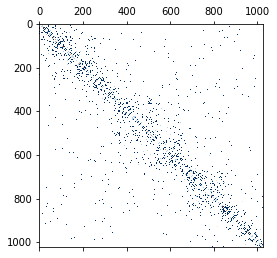

In [8]:
scale = 4
len_size = 512 
IMG_HEIGHT, IMG_WIDTH = int(Mh.shape[0]/scale), int(Mh.shape[1]/scale)
img_l = sampling_hic(Mh, scale**2)

Ml = img_l
print('ML: ', Ml.shape)
plt.matshow(np.log2(Ml), cmap='RdBu_r')


In [9]:
"""scale = 1
IMG_HEIGHT, IMG_WIDTH = int(Mh.shape[0]/scale), int(Mh.shape[1]/scale)
img_l = sampling_hic(Mh, scale**2)

Ml = img_l
print('ML: ', Ml.shape)
plt.matshow(np.log2(Ml), cmap='RdBu_r')"""

"scale = 1\nIMG_HEIGHT, IMG_WIDTH = int(Mh.shape[0]/scale), int(Mh.shape[1]/scale)\nimg_l = sampling_hic(Mh, scale**2)\n\nMl = img_l\nprint('ML: ', Ml.shape)\nplt.matshow(np.log2(Ml), cmap='RdBu_r')"

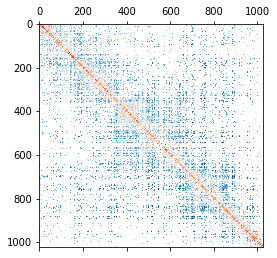

In [10]:
plt.matshow(np.log2(Mh), cmap='RdBu_r')

In [55]:
copy_Ml = copy.copy(Ml)
copy_Mh = copy.copy(Mh)

In [24]:
print(Ml)

[[2. 1. 0. ... 0. 0. 0.]
 [1. 0. 2. ... 0. 0. 0.]
 [0. 2. 4. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 1.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]


In [22]:
Ml_0 = normalization.SCN_normalization(copy_Ml)
Mh_0 = normalization.SCN_normalization(copy_Mh)
print(np.sum(np.multiply(copy_Ml[0:128,0:128], copy_Ml[0:128,0:128])))
print(np.sum(np.multiply(copy_Mh[0:128,0:128], copy_Mh[0:128,0:128])))
print(np.sum(np.multiply(Ml_0[0:128,0:128], Ml_0[0:128,0:128])))
print(np.sum(np.multiply(Mh_0[0:128,0:128], Mh_0[0:128,0:128])))

break at iteration 99
break at iteration 173
5740.0
601643.8692543143
4.220856309301892
113.88768280935633


In [25]:
print(np.asarray(Ml))

[[2. 1. 0. ... 0. 0. 0.]
 [1. 0. 2. ... 0. 0. 0.]
 [0. 2. 4. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 1.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]


In [27]:
# Normalization
Ml_nas = np.asarray(Ml)
Mh_nas = np.asarray(Mh)
Ml_1 = normalization.SCN_normalization(Ml_nas)
Mh_1 = normalization.SCN_normalization(Mh_nas)
print(np.sum(np.multiply(Ml_nas[0:128,0:128], Ml_nas[0:128,0:128])))
print(np.sum(np.multiply(Mh_nas[0:128,0:128], Mh_nas[0:128,0:128])))
print(np.sum(np.multiply(Ml_1[0:128,0:128], Ml_1[0:128,0:128])))
print(np.sum(np.multiply(Mh_1[0:128,0:128], Mh_1[0:128,0:128])))

break at iteration 66
break at iteration 173
5740.0
601643.8692543143
100.2493964931507
113.88768280935633


In [70]:
def SCN(X, max_iter=1, eps=1e-6, copy=True):
    for it in np.arange(max_iter):
        sum_X = np.sqrt((X ** 2).sum(0))
        sum_X[sum_X == 0] = 1
        print(X)
        print('sum', sum_X)
        X /= sum_X
        X = X.T
        print(X)
        sum_X = np.sqrt((X ** 2).sum(0))
        sum_X[sum_X == 0] = 1
        X /= sum_X
        X = X.T
        if np.abs(X - X.T).sum() < eps:
            print("break at iteration %d" % (it,))
            break
    return X

In [77]:
copy_Ml = copy.copy(Ml)
copy_Mh = copy.copy(Mh)
copy_Ml = copy_Ml[0:2,0:2]
print(type(copy_Ml))
print((copy_Ml**2).sum(0))

#SCN(copy_Ml)

SyntaxError: invalid syntax (<ipython-input-77-357d00033b81>, line 5)

In [82]:
A = np.matrix(np.ones((2,2)))
print(A**2)

A = np.asarray(np.ones((2,2)))
print(A**2)



[[2. 2.]
 [2. 2.]]
[[1. 1.]
 [1. 1.]]


In [76]:
Ml_nas = np.asarray(Ml)
Mh_nas = np.asarray(Mh)
copy_Ml1 = copy.copy(Ml_nas)
copy_Mh1 = copy.copy(Mh_nas)
copy_Ml1 = copy_Ml1[0:2,0:2]
print(type(copy_Ml1))
print((copy_Ml1**2).sum(0))

#SCN(copy_Ml1)

<class 'numpy.ndarray'>
[1.04520206 0.95479794]


In [62]:
print(type(copy_Ml))
print(type(copy_Mh))
print(type(Ml_nas))
print(type(Mh_nas))
print(copy_Ml.sum(0).shape)
print(Ml_nas.sum(0).shape)

<class 'numpy.matrix'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(1, 1024)
(1024,)


In [20]:
# Normalization
Ml = np.asarray(Ml)
Mh = np.asarray(Mh)
Ml = normalization.SCN_normalization(Ml)
Mh = normalization.SCN_normalization(Mh)
print(np.sum(np.multiply(Ml[0:128,0:128], Ml[0:128,0:128])))
print(np.sum(np.multiply(Mh[0:128,0:128], Mh[0:128,0:128])))

break at iteration 69
break at iteration 185
102.05345643096007
113.88768281218927


In [ ]:
K = np.zeros((4,4,256,256))
for i in np.arange(4):
    for j in np.arange(4):
        K[i,j,:,:] = Mh[i::4,j::4]

In [ ]:
fig = plt.figure(figsize=(10,10))
for i in np.arange(4):
    for j in np.arange(4):
        id = i*4+j+1
        plt.subplot(4,4,id)
        plt.imshow(np.log1p(1000*np.squeeze(K[i,j,:,:])), cmap='RdBu_r')
plt.show()

In [ ]:
import tensorflow as tf

y_pred = tf.ones(shape=(15,4,4,1))
y_true = tf.zeros_like(y_pred)

diff = tf.math.squared_difference(y_pred, y_true)
s = tf.reduce_sum(diff, axis=-1)
print(s)
s = tf.reduce_sum(s, axis=-1)
print(s)
s = tf.reduce_mean(s, axis=-1)
print(s)

In [ ]:
np.sqrt(0.07/128)